# Anomaly Detection

In [118]:
import  pandas as pd
import numpy as np
import scipy.stats as stats
import pylab as pl

In [119]:
pd.options.mode.chained_assignment = None

# Importing data

1. We have imported **56133 records** with **35 columns**.
2. Data ranges from **April 3, 2018 to April 8, 2020**.
3. We have **463 unique distributors** in **Southern region** of India in **General Trade**

In [120]:
%%time
data = pd.read_excel(r"E:\0001_Studies\Undercutting\2018-2020.xlsx",sheet_name= "Sheet1")

Wall time: 48 s


In [117]:
data.shape

(56133, 37)

In [5]:
data.head(2)

,Distribution Channel,Division,Old Sold-To Party,Sold-To Party,Customer Group 3,Price List Type,Region Order,Plant,Material,Date,...,Gross,Gross.1,Sales cost,Sales cost.1,Net,Net.1,RtnsQty,RtnsQty.1,Rtns (cst),Rtns (cst).1
0,GT General Trade,PC Personal Care,2000001 N.CT. AGENCIES,2000001 N.CT. AGENCIES,006 GT,02 Super Stockist,TN TN,PYC1 CAVINKARE PVT LTD,KH0180HWP02R KARTHIKA HERBAL POWDER CONT...,23.10.2019,...,187.0,KG,15169.7,INR,144.0,KG,0.0,CV,0.0,INR
1,GT General Trade,PC Personal Care,2000001 N.CT. AGENCIES,2000001 N.CT. AGENCIES,006 GT,02 Super Stockist,TN TN,PYC1 CAVINKARE PVT LTD,KH05D8HWP02R KARTHIKA HERBAL POWDER 5.8 ...,10.07.2019,...,5040.0,KG,272536.0,INR,4640.0,KG,0.0,CV,0.0,INR


In [6]:
data.columns

Index(['Distribution Channel', 'Division', 'Old Sold-To Party',
       'Sold-To Party', 'Customer Group 3', 'Price List Type', 'Region Order',
       'Plant', 'Material', 'Date', 'Sales', 'Sales.1', 'Returns',
       'Cred.Memos', 'Cred.Memos.1', 'CM: net 1', 'CM: net 1.1', 'Net Value',
       'Net Value.1', 'Tax', 'Tax.1', 'Bill. Qty', 'Bill. Qty.1', 'CredMemQty',
       'CredMemQty.1', 'Gross', 'Gross.1', 'Sales cost', 'Sales cost.1', 'Net',
       'Net.1', 'RtnsQty', 'RtnsQty.1', 'Rtns (cst)', 'Rtns (cst).1'],
      dtype='object')

# Data Transformation and Feature Engineering

In [7]:
temp                   =  data["Material"].str.split("       ",expand=True)
data["Prod_Code"]      = temp[0]
data["Prod_Name"]      = temp[1]
data["Date"]           = pd.to_datetime(data["Date"],format='%d.%m.%Y')
# data["Month"]          = data["New date"].dt.strftime('%B')

In [8]:
dist_data = data[["Sold-To Party","Date","Prod_Name","Bill. Qty"]]

In [9]:
p = dist_data['Prod_Name']
p = p.drop_duplicates()

In [10]:
p

0        KARTHIKA HERBAL POWDER CONT 180G 80PCS
1        KARTHIKA HERBAL POWDER 5.8 GM 2000 PCS
20      MEERA ADVANCE HW POWDER 5.6 GM 1350 PCS
49       MEERA HERBAL POWDER 80GM REFILL 50 PCS
51        MEERA HERBAL POWDER 120GM CONT 60 PCS
55          MEERA HERBAL POWDER 5.6 GM 1350 PCS
61          KARTHIKA HERBAL POWDER 50GM 180 PCS
124            MEERA HERBAL POWDER 5GM 1350 PCS
125      MEERA HERBAL POWDER 40GM REFILL 100PCS
138    MEERA ADVANCE HW POWDER 80GM REFILL 50 P
163    MEERA ADVANCE HW POWDER 120GM CONT 60 PC
Name: Prod_Name, dtype: object

In [11]:
dist_data = dist_data[dist_data["Bill. Qty"] != 0]

In [12]:
dist_data.shape

(54133, 4)

In [13]:
dist_data.head(2)

,Sold-To Party,Date,Prod_Name,Bill. Qty
0,2000001 N.CT. AGENCIES,2019-10-23,KARTHIKA HERBAL POWDER CONT 180G 80PCS,10.0
1,2000001 N.CT. AGENCIES,2019-07-10,KARTHIKA HERBAL POWDER 5.8 GM 2000 PCS,400.0


## Removing single records

In [14]:
rmv_single_rows = dist_data.groupby(["Sold-To Party","Prod_Name"]).agg(Count = ("Prod_Name","count")).reset_index()
rmv_single_rows.head(2)

,Sold-To Party,Prod_Name,Count
0,2000001 N.CT. AGENCIES,KARTHIKA HERBAL POWDER 5.8 GM 2000 PCS,104
1,2000001 N.CT. AGENCIES,KARTHIKA HERBAL POWDER 50GM 180 PCS,24


In [15]:
len(rmv_single_rows[rmv_single_rows["Count"] == 1])

294

In [16]:
dist_data_clean = pd.merge(dist_data,rmv_single_rows,on = ["Sold-To Party","Prod_Name"],how = "left")
dist_data_clean = dist_data_clean[dist_data_clean["Count"] != 1]
dist_data_clean.shape

(53839, 5)

In [17]:
print("So totally {a} rows will be dropped from total of {b} rows. Because it has only 1 data".format(a = len(rmv_single_rows[rmv_single_rows["Count"] == 1]), b= len(dist_data)))

So totally 294 rows will be dropped from total of 54133 rows. Because it has only 1 data


In [18]:
dist_data_clean.head(2)

,Sold-To Party,Date,Prod_Name,Bill. Qty,Count
0,2000001 N.CT. AGENCIES,2019-10-23,KARTHIKA HERBAL POWDER CONT 180G 80PCS,10.0,60
1,2000001 N.CT. AGENCIES,2019-07-10,KARTHIKA HERBAL POWDER 5.8 GM 2000 PCS,400.0,104


After removing we have 56133 records for analysis

# Descriptive Analytics

In [19]:
dist_data_descriptive = dist_data_clean.groupby(["Sold-To Party","Prod_Name"]).agg(Mean = ("Bill. Qty","mean"), 
                                           stddev = ("Bill. Qty","std"),Median =("Bill. Qty","median")).reset_index()
dist_data_descriptive.isna().sum()

Sold-To Party    0
Prod_Name        0
Mean             0
stddev           0
Median           0
dtype: int64

In [20]:
zscore_data = pd.merge(dist_data_clean, dist_data_descriptive, on = ["Sold-To Party","Prod_Name"], how = 'left')

In [21]:
zscore_data.isna().sum()
# zscore_data.dropna(axis = 0, inplace = True)

Sold-To Party    0
Date             0
Prod_Name        0
Bill. Qty        0
Count            0
Mean             0
stddev           0
Median           0
dtype: int64

In [22]:
zscore_data

,Sold-To Party,Date,Prod_Name,Bill. Qty,Count,Mean,stddev,Median
0,2000001 N.CT. AGENCIES,2019-10-23,KARTHIKA HERBAL POWDER CONT 180G 80PCS,10.0,60,2.816667,2.626409,2.0
1,2000001 N.CT. AGENCIES,2019-07-10,KARTHIKA HERBAL POWDER 5.8 GM 2000 PCS,400.0,104,178.009615,156.689570,146.5
2,2000001 N.CT. AGENCIES,2019-07-16,KARTHIKA HERBAL POWDER 5.8 GM 2000 PCS,150.0,104,178.009615,156.689570,146.5
3,2000001 N.CT. AGENCIES,2019-07-23,KARTHIKA HERBAL POWDER 5.8 GM 2000 PCS,260.0,104,178.009615,156.689570,146.5
4,2000001 N.CT. AGENCIES,2019-07-29,KARTHIKA HERBAL POWDER 5.8 GM 2000 PCS,192.0,104,178.009615,156.689570,146.5
...,...,...,...,...,...,...,...,...
53834,2001017,2018-05-28,MEERA HERBAL POWDER 120GM CONT 60 PCS,1.0,3,1.666667,1.154701,1.0
53835,2003456 JPL ASSOCIATES,2019-03-19,MEERA HERBAL POWDER 40GM REFILL 100PCS,1.0,4,1.000000,0.000000,1.0
53836,2003456 JPL ASSOCIATES,2019-03-19,MEERA HERBAL POWDER 80GM REFILL 50 PCS,1.0,3,1.000000,0.000000,1.0
53837,2003456 JPL ASSOCIATES,2019-03-19,MEERA HERBAL POWDER 120GM CONT 60 PCS,2.0,8,1.625000,0.517549,2.0


### Consider Only one Distributor

In [23]:
# Test Data
zscore_data = zscore_data[(zscore_data["Sold-To Party"] == "2000082    HARISH KANNA AGENCY")]
zscore_data
# "2000082    HARISH KANNA AGENCY"
# "2000001    N.CT. AGENCIES"
# "2000168    SAI SRI SARAN AGENCY"

,Sold-To Party,Date,Prod_Name,Bill. Qty,Count,Mean,stddev,Median
4098,2000082 HARISH KANNA AGENCY,2019-04-03,KARTHIKA HERBAL POWDER 50GM 180 PCS,1.0,87,2.000000,1.00000,2.0
4099,2000082 HARISH KANNA AGENCY,2019-04-16,KARTHIKA HERBAL POWDER 50GM 180 PCS,2.0,87,2.000000,1.00000,2.0
4100,2000082 HARISH KANNA AGENCY,2019-04-27,KARTHIKA HERBAL POWDER 50GM 180 PCS,3.0,87,2.000000,1.00000,2.0
4101,2000082 HARISH KANNA AGENCY,2019-05-03,KARTHIKA HERBAL POWDER 50GM 180 PCS,2.0,87,2.000000,1.00000,2.0
4102,2000082 HARISH KANNA AGENCY,2019-05-10,KARTHIKA HERBAL POWDER 50GM 180 PCS,2.0,87,2.000000,1.00000,2.0
...,...,...,...,...,...,...,...,...
30303,2000082 HARISH KANNA AGENCY,2019-02-21,MEERA HERBAL POWDER 5.6 GM 1350 PCS,22.0,66,21.242424,12.72195,20.0
30304,2000082 HARISH KANNA AGENCY,2019-03-01,MEERA HERBAL POWDER 5.6 GM 1350 PCS,15.0,66,21.242424,12.72195,20.0
30305,2000082 HARISH KANNA AGENCY,2019-03-08,MEERA HERBAL POWDER 5.6 GM 1350 PCS,32.0,66,21.242424,12.72195,20.0
30306,2000082 HARISH KANNA AGENCY,2019-03-15,MEERA HERBAL POWDER 5.6 GM 1350 PCS,28.0,66,21.242424,12.72195,20.0


### Univariate

### Method 1 - Z Score Calculation

Z score = (Observation - Mean)/Sigma

In [24]:
zscore_data['z-score']= (zscore_data['Bill. Qty'] - zscore_data['Mean'])/zscore_data['stddev']

In [25]:
zscore_data.sort_values(by='z-score', ascending=False,inplace=True)
zscore_data.head(5)

,Sold-To Party,Date,Prod_Name,Bill. Qty,Count,Mean,stddev,Median,z-score
30106,2000082 HARISH KANNA AGENCY,2018-08-22,KARTHIKA HERBAL POWDER 5.8 GM 2000 PCS,102.0,105,34.352381,16.504068,31.0,4.098845
30062,2000082 HARISH KANNA AGENCY,2018-09-27,KARTHIKA HERBAL POWDER CONT 180G 80PCS,5.0,87,1.758621,0.939638,2.0,3.449605
4161,2000082 HARISH KANNA AGENCY,2019-09-10,KARTHIKA HERBAL POWDER CONT 180G 80PCS,5.0,87,1.758621,0.939638,2.0,3.449605
4162,2000082 HARISH KANNA AGENCY,2019-09-25,KARTHIKA HERBAL POWDER CONT 180G 80PCS,5.0,87,1.758621,0.939638,2.0,3.449605
30238,2000082 HARISH KANNA AGENCY,2018-09-27,MEERA HERBAL POWDER 120GM CONT 60 PCS,21.0,54,7.018519,4.507816,5.5,3.101609


### Method 2 - Mod Z Score Calculation - IBM formula

MAD - Median Absolute deviation        
MAD = Median(ABS(observation - Median))       

MeanAD - Mean Absolute deviation     
MeanAD = Mean(ABS(Observation - Mean))      
            

In [26]:
zscore_data['MAD Bill. Qty'] = np.absolute(zscore_data['Bill. Qty'] - zscore_data['Median']) #abs(x-median)
zscore_data['MeanAD Bill. Qty'] = np.absolute(zscore_data['Bill. Qty'] - zscore_data['Mean']) #abs(x-mean)

In [27]:
MeanAD_MAD_Group = zscore_data.groupby(["Sold-To Party","Prod_Name"]).agg(MAD = ("MAD Bill. Qty","median"),
                                                                          MeanAD = ("MeanAD Bill. Qty","mean")).reset_index()

In [28]:
MeanAD_MAD_Group.head(2)

,Sold-To Party,Prod_Name,MAD,MeanAD
0,2000082 HARISH KANNA AGENCY,KARTHIKA HERBAL POWDER 5.8 GM 2000 PCS,9.0,12.416145
1,2000082 HARISH KANNA AGENCY,KARTHIKA HERBAL POWDER 50GM 180 PCS,1.0,0.643678


In [29]:
zscore_data = pd.merge(zscore_data,MeanAD_MAD_Group,on=["Sold-To Party","Prod_Name"],how='left')

In [30]:
zscore_data

,Sold-To Party,Date,Prod_Name,Bill. Qty,Count,Mean,stddev,Median,z-score,MAD Bill. Qty,MeanAD Bill. Qty,MAD,MeanAD
0,2000082 HARISH KANNA AGENCY,2018-08-22,KARTHIKA HERBAL POWDER 5.8 GM 2000 PCS,102.0,105,34.352381,16.504068,31.0,4.098845,71.0,67.647619,9.0,12.416145
1,2000082 HARISH KANNA AGENCY,2018-09-27,KARTHIKA HERBAL POWDER CONT 180G 80PCS,5.0,87,1.758621,0.939638,2.0,3.449605,3.0,3.241379,1.0,0.715022
2,2000082 HARISH KANNA AGENCY,2019-09-10,KARTHIKA HERBAL POWDER CONT 180G 80PCS,5.0,87,1.758621,0.939638,2.0,3.449605,3.0,3.241379,1.0,0.715022
3,2000082 HARISH KANNA AGENCY,2019-09-25,KARTHIKA HERBAL POWDER CONT 180G 80PCS,5.0,87,1.758621,0.939638,2.0,3.449605,3.0,3.241379,1.0,0.715022
4,2000082 HARISH KANNA AGENCY,2018-09-27,MEERA HERBAL POWDER 120GM CONT 60 PCS,21.0,54,7.018519,4.507816,5.5,3.101609,15.5,13.981481,1.5,3.320988
...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,2000082 HARISH KANNA AGENCY,2019-01-24,MEERA HERBAL POWDER 5.6 GM 1350 PCS,1.0,66,21.242424,12.721950,20.0,-1.591142,19.0,20.242424,8.0,9.596878
590,2000082 HARISH KANNA AGENCY,2018-04-20,MEERA HERBAL POWDER 5.6 GM 1350 PCS,1.0,66,21.242424,12.721950,20.0,-1.591142,19.0,20.242424,8.0,9.596878
591,2000082 HARISH KANNA AGENCY,2018-08-25,KARTHIKA HERBAL POWDER 5.8 GM 2000 PCS,8.0,105,34.352381,16.504068,31.0,-1.596720,23.0,26.352381,9.0,12.416145
592,2000082 HARISH KANNA AGENCY,2019-11-16,MEERA ADVANCE HW POWDER 5.6 GM 1350 PCS,3.0,37,21.459459,11.410508,20.0,-1.617760,17.0,18.459459,5.0,8.271731


# Mod Z Score formula:

**Formula1** : If MAD = 0 then, (X-MED)/(1.253314 * MeanAD)   
**Formula2** : If MAD != 0 then, (X-MED)/(1.486 * MAD)   


In [31]:
MAD_data_equal0   = zscore_data[zscore_data['MAD'] == 0]
MAD_data_greater0 = zscore_data[zscore_data['MAD']  > 0]

In [32]:
MAD_data_equal0.shape

(0, 13)

In [33]:
MAD_data_greater0.shape

(594, 13)

So we will using Formula 1 for 27% of the records and formula 2 for the rest 73% of the records

**Formula1** : If Median = 0 then, (X-MED)/(1.253314 * MeanAD)  

In [34]:

MAD_data_equal0['Mod-z_score'] = MAD_data_equal0['MAD Bill. Qty']/(1.253314 * MAD_data_equal0['MeanAD']) 

In [35]:
MAD_data_greater0['Mod-z_score'] = MAD_data_greater0['MAD Bill. Qty']/(1.486 * MAD_data_greater0['MAD']) 

In [36]:
MAD_data_greater0.head(5)

,Sold-To Party,Date,Prod_Name,Bill. Qty,Count,Mean,stddev,Median,z-score,MAD Bill. Qty,MeanAD Bill. Qty,MAD,MeanAD,Mod-z_score
0,2000082 HARISH KANNA AGENCY,2018-08-22,KARTHIKA HERBAL POWDER 5.8 GM 2000 PCS,102.0,105,34.352381,16.504068,31.0,4.098845,71.0,67.647619,9.0,12.416145,5.308808
1,2000082 HARISH KANNA AGENCY,2018-09-27,KARTHIKA HERBAL POWDER CONT 180G 80PCS,5.0,87,1.758621,0.939638,2.0,3.449605,3.0,3.241379,1.0,0.715022,2.018843
2,2000082 HARISH KANNA AGENCY,2019-09-10,KARTHIKA HERBAL POWDER CONT 180G 80PCS,5.0,87,1.758621,0.939638,2.0,3.449605,3.0,3.241379,1.0,0.715022,2.018843
3,2000082 HARISH KANNA AGENCY,2019-09-25,KARTHIKA HERBAL POWDER CONT 180G 80PCS,5.0,87,1.758621,0.939638,2.0,3.449605,3.0,3.241379,1.0,0.715022,2.018843
4,2000082 HARISH KANNA AGENCY,2018-09-27,MEERA HERBAL POWDER 120GM CONT 60 PCS,21.0,54,7.018519,4.507816,5.5,3.101609,15.5,13.981481,1.5,3.320988,6.953791


In [37]:
zscore_data = MAD_data_equal0.append(MAD_data_greater0)

In [38]:
zscore_data.isna().sum()

Sold-To Party       0
Date                0
Prod_Name           0
Bill. Qty           0
Count               0
Mean                0
stddev              0
Median              0
z-score             0
MAD Bill. Qty       0
MeanAD Bill. Qty    0
MAD                 0
MeanAD              0
Mod-z_score         0
dtype: int64

In [39]:
zscore_data["z-score"].fillna(0,inplace=True)

In [40]:
zscore_data["Mod-z_score"].fillna(0,inplace= True)

In [41]:
zscore_data.head(5)

,Sold-To Party,Date,Prod_Name,Bill. Qty,Count,Mean,stddev,Median,z-score,MAD Bill. Qty,MeanAD Bill. Qty,MAD,MeanAD,Mod-z_score
0,2000082 HARISH KANNA AGENCY,2018-08-22,KARTHIKA HERBAL POWDER 5.8 GM 2000 PCS,102.0,105,34.352381,16.504068,31.0,4.098845,71.0,67.647619,9.0,12.416145,5.308808
1,2000082 HARISH KANNA AGENCY,2018-09-27,KARTHIKA HERBAL POWDER CONT 180G 80PCS,5.0,87,1.758621,0.939638,2.0,3.449605,3.0,3.241379,1.0,0.715022,2.018843
2,2000082 HARISH KANNA AGENCY,2019-09-10,KARTHIKA HERBAL POWDER CONT 180G 80PCS,5.0,87,1.758621,0.939638,2.0,3.449605,3.0,3.241379,1.0,0.715022,2.018843
3,2000082 HARISH KANNA AGENCY,2019-09-25,KARTHIKA HERBAL POWDER CONT 180G 80PCS,5.0,87,1.758621,0.939638,2.0,3.449605,3.0,3.241379,1.0,0.715022,2.018843
4,2000082 HARISH KANNA AGENCY,2018-09-27,MEERA HERBAL POWDER 120GM CONT 60 PCS,21.0,54,7.018519,4.507816,5.5,3.101609,15.5,13.981481,1.5,3.320988,6.953791


### Method 3 - MADe Calculation

Median Absolute Deviation (MADe) method is one of the basic robust methods which are largely unaffected by the presence of extreme values of the data set

##### 2MADe Method = Median +/- 2MADe and 3MADe Method = Median +/- 3MADe 
##### where MADe = 1.483 × MAD and MAD = median {|xi −median(x)|}, i = 1,2,...,n

In [42]:
zscore_data['MADe'] = 1.483 * zscore_data['MAD']

In [43]:
zscore_data['Lower_lt'] = zscore_data['Median'] - (3 * zscore_data['MADe'])
zscore_data['Upper_lt'] = zscore_data['Median'] + (3 * zscore_data['MADe'])

In [44]:
zscore_data['3MADe'] = 'Not Outlier'

In [45]:
zscore_data.loc[(zscore_data['Bill. Qty'] < zscore_data['Lower_lt']) | (zscore_data['Bill. Qty'] > zscore_data['Upper_lt']), '3MADe'] = zscore_data['Bill. Qty']

In [46]:
zscore_data

,Sold-To Party,Date,Prod_Name,Bill. Qty,Count,Mean,stddev,Median,z-score,MAD Bill. Qty,MeanAD Bill. Qty,MAD,MeanAD,Mod-z_score,MADe,Lower_lt,Upper_lt,3MADe
0,2000082 HARISH KANNA AGENCY,2018-08-22,KARTHIKA HERBAL POWDER 5.8 GM 2000 PCS,102.0,105,34.352381,16.504068,31.0,4.098845,71.0,67.647619,9.0,12.416145,5.308808,13.3470,-9.0410,71.0410,102
1,2000082 HARISH KANNA AGENCY,2018-09-27,KARTHIKA HERBAL POWDER CONT 180G 80PCS,5.0,87,1.758621,0.939638,2.0,3.449605,3.0,3.241379,1.0,0.715022,2.018843,1.4830,-2.4490,6.4490,Not Outlier
2,2000082 HARISH KANNA AGENCY,2019-09-10,KARTHIKA HERBAL POWDER CONT 180G 80PCS,5.0,87,1.758621,0.939638,2.0,3.449605,3.0,3.241379,1.0,0.715022,2.018843,1.4830,-2.4490,6.4490,Not Outlier
3,2000082 HARISH KANNA AGENCY,2019-09-25,KARTHIKA HERBAL POWDER CONT 180G 80PCS,5.0,87,1.758621,0.939638,2.0,3.449605,3.0,3.241379,1.0,0.715022,2.018843,1.4830,-2.4490,6.4490,Not Outlier
4,2000082 HARISH KANNA AGENCY,2018-09-27,MEERA HERBAL POWDER 120GM CONT 60 PCS,21.0,54,7.018519,4.507816,5.5,3.101609,15.5,13.981481,1.5,3.320988,6.953791,2.2245,-1.1735,12.1735,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,2000082 HARISH KANNA AGENCY,2019-01-24,MEERA HERBAL POWDER 5.6 GM 1350 PCS,1.0,66,21.242424,12.721950,20.0,-1.591142,19.0,20.242424,8.0,9.596878,1.598250,11.8640,-15.5920,55.5920,Not Outlier
590,2000082 HARISH KANNA AGENCY,2018-04-20,MEERA HERBAL POWDER 5.6 GM 1350 PCS,1.0,66,21.242424,12.721950,20.0,-1.591142,19.0,20.242424,8.0,9.596878,1.598250,11.8640,-15.5920,55.5920,Not Outlier
591,2000082 HARISH KANNA AGENCY,2018-08-25,KARTHIKA HERBAL POWDER 5.8 GM 2000 PCS,8.0,105,34.352381,16.504068,31.0,-1.596720,23.0,26.352381,9.0,12.416145,1.719755,13.3470,-9.0410,71.0410,Not Outlier
592,2000082 HARISH KANNA AGENCY,2019-11-16,MEERA ADVANCE HW POWDER 5.6 GM 1350 PCS,3.0,37,21.459459,11.410508,20.0,-1.617760,17.0,18.459459,5.0,8.271731,2.288022,7.4150,-2.2450,42.2450,Not Outlier


## Output 1

In [47]:
zscore_data.to_excel(r"E:\0001_Studies\Undercutting\output\comparison\Test\HARISH KANNA AGENCY_Analysis.xlsx",index = False)

# Outlier Detection

### Multivariate Analysis

In [566]:
zscore_data.head(2)

,Sold-To Party,Date,Prod_Name,Bill. Qty,Count,Mean,stddev,Median,z-score,MAD Bill. Qty,MeanAD Bill. Qty,MAD,MeanAD,Mod-z_score,MADe,Lower_lt,Upper_lt,3MADe
0,2000082 HARISH KANNA AGENCY,2018-08-22,KARTHIKA HERBAL POWDER 5.8 GM 2000 PCS,102.0,105,34.352381,16.504068,31.0,4.098845,71.0,67.647619,9.0,12.416145,5.308808,13.347,-9.041,71.041,102
1,2000082 HARISH KANNA AGENCY,2018-09-27,KARTHIKA HERBAL POWDER CONT 180G 80PCS,5.0,87,1.758621,0.939638,2.0,3.449605,3.0,3.241379,1.0,0.715022,2.018843,1.483,-2.449,6.449,Not Outlier


###  Separate the Distributor Dataframe w.r.t  Products 

In [48]:
from statsmodels.tsa.seasonal import seasonal_decompose

Product = zscore_data['Prod_Name'].unique()

frames = []
period = []

for i in Product:
    df = zscore_data[zscore_data['Prod_Name']==i][['Date','Bill. Qty','Prod_Name']]
    df.sort_values(by='Date',ascending=True,inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    #print(df)
    start_date = (df['Date'].iloc[0])
    end_date = (df['Date'].iloc[-1])
    #print(start_date,"   ",end_date)
    diff = ((end_date - start_date)/np.timedelta64(1, 'M'))
    #print(diff)
    period.append(int(diff)-1)
    df1 = df.groupby(['Date']).sum()  
    frames.append(df1)

In [49]:
len(frames)

10

In [50]:
#len(frames)
len(period)

10

In [51]:
Product

array(['KARTHIKA HERBAL POWDER 5.8 GM 2000 PCS',
       'KARTHIKA HERBAL POWDER CONT 180G 80PCS',
       'MEERA HERBAL POWDER 120GM CONT 60 PCS',
       'MEERA HERBAL POWDER 80GM REFILL 50 PCS',
       'MEERA ADVANCE HW POWDER 80GM REFILL 50 P',
       'MEERA HERBAL POWDER 5.6 GM 1350 PCS',
       'MEERA ADVANCE HW POWDER 120GM CONT 60 PC',
       'KARTHIKA HERBAL POWDER 50GM 180 PCS',
       'MEERA HERBAL POWDER 40GM REFILL 100PCS',
       'MEERA ADVANCE HW POWDER 5.6 GM 1350 PCS'], dtype=object)

### Decompose using STL Decomposition

In [52]:
decomposition = []
for i in range(0,len(Product)-1):
    try:
        decomposition.append(seasonal_decompose(frames[i], model='additive', period=period[i]))
    except:
        decomposition.append(0)

#### Distributor : Product 1: KARTHIKA HERBAL POWDER CONT 180G 80PCS

In [113]:
index = 9
dec0 = seasonal_decompose(frames[index], model='additive', period=period[index])
value = Product[index]

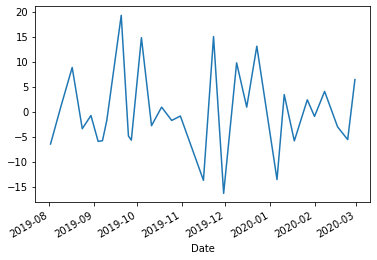

In [114]:
plot = dec0.resid.plot()
fig = plot.get_figure()
path = r'E:\0001_Studies\Undercutting\output\comparison\HARISH KANNA AGENCY\image\Res_'+Product[index]+'.png'
fig.savefig(path)

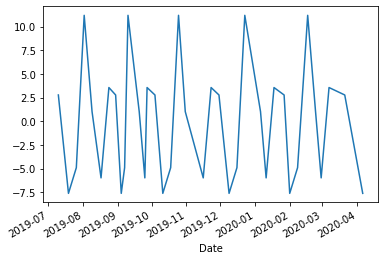

In [115]:
plot1 = dec0.seasonal.plot()
fig1 = plot1.get_figure()
path1 = r'E:\0001_Studies\Undercutting\output\comparison\HARISH KANNA AGENCY\image\Season_'+Product[index]+'.png'
fig1.savefig(path1)

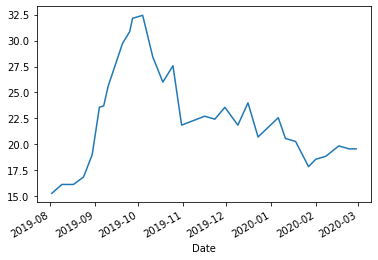

In [116]:
plot2 = dec0.trend.plot()
fig2 = plot2.get_figure()
path2 = r'E:\0001_Studies\Undercutting\output\comparison\HARISH KANNA AGENCY\image\Trend_'+Product[index]+'.png'
fig2.savefig(path2)


#### Distributor : Product 2: KARTHIKA HERBAL POWDER 5.8 GM 2000 PCS

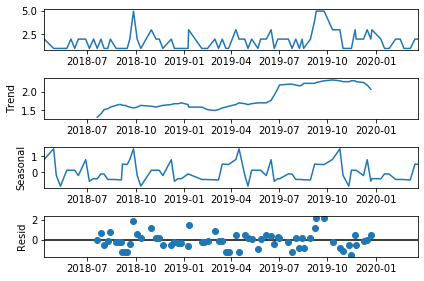

In [573]:
index = 1
dec1 = seasonal_decompose(frames[index], model='additive', period=period[index]).plot()

### Storing the Decomposed value (Seasonality, Trend, Residue) for all products 

## Output 2

In [574]:
for i in range(0,len(decomposition)-1):
    output_filepath = r'E:\0001_Studies\Undercutting\output\comparison\Test\HARISH KANNA AGENCY_'+Product[i]+'.xlsx'   
    
    try:
        res = decomposition[i].resid 
        trend = decomposition[i].trend
        seasonal = decomposition[i].seasonal
        observation = decomposition[i].observed

        # Create a Pandas Excel writer using XlsxWriter as the engine.
        writer = pd.ExcelWriter(output_filepath, engine='xlsxwriter')

        # Write each dataframe to a different worksheet.
        observation.to_excel(writer, sheet_name='observation')
        seasonal.to_excel(writer, sheet_name='seasonal')
        trend.to_excel(writer, sheet_name='trend')
        res.to_excel(writer, sheet_name='res')

        # Close the Pandas Excel writer and output the Excel file.
        writer.save()
    except:
        pd.DataFrame({}).to_excel(output_filepath)

## Testing - Applying ESD over Residual 

### Preprocessing data for Seasonal_H-ESD

In [575]:
import numpy as np
import sesd

from statsmodels.tsa.seasonal import seasonal_decompose

Product = zscore_data['Prod_Name'].unique()
frames = []
period = []

for i in Product:
    df = zscore_data[zscore_data['Prod_Name']==i][['Date','Bill. Qty','Prod_Name']]
    pdt = zscore_data['Prod_Name']
    df.sort_values(by='Date',ascending=True,inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    #print(df)
    start_date = (df['Date'].iloc[0])
    end_date = (df['Date'].iloc[-1])
    #print(start_date,"   ",end_date)
    diff = ((end_date - start_date)/np.timedelta64(1, 'M'))
    #print(diff)
    period.append(int(diff)-1)
    df1 = df.groupby(['Date']).sum().reset_index()
    frames.append(df1)

In [576]:
period

[21, 22, 14, 12, 8, 14, 6, 22, 13, 7]

### Seasonal H-ESD

In [577]:
import numpy as np
import sesd

outliers_indices = []

for i in range(0,len(period)):
    try:
        out = sesd.seasonal_esd(frames[i]['Bill. Qty'], periodicity=period[i], hybrid=True, max_anomalies=6, alpha=0.05)
        outliers_indices.append(out)
    except: 
        out = sesd.seasonal_esd(frames[i]['Bill. Qty'], periodicity=period[i], hybrid=True, max_anomalies=1, alpha=0.05)
        outliers_indices.append(out)

# outliers_indices

In [578]:
outliers_indices

[[23, 44, 33, 76, 48, 39],
 [64, 23, 63, 43, 35, 26],
 [23, 24, 25, 35, 15, 31],
 [14, 17, 18, 33, 32, 24],
 [10, 9, 14, 12, 11],
 [21, 27, 28, 26, 37, 40],
 [11, 10, 14, 12],
 [56, 44, 43, 33, 22],
 [15, 16, 17, 29, 25, 22],
 [11, 14, 20, 24, 19, 22]]

In [509]:
#data = {'Bill. Qty':['0'],'Date':['0000']}
#null_frame = pd.DataFrame(data)

In [579]:
output = []
i=0
while (i<10):
    for idx in outliers_indices:
        for edx in idx:
            res = frames[i].iloc[edx][['Bill. Qty','Date']]
            output.append(res)
        i=i+1

In [580]:
output

[Bill. Qty                    102
 Date         2018-08-22 00:00:00
 Name: 23, dtype: object,
 Bill. Qty                     83
 Date         2019-01-19 00:00:00
 Name: 44, dtype: object,
 Bill. Qty                     73
 Date         2018-11-02 00:00:00
 Name: 33, dtype: object,
 Bill. Qty                     14
 Date         2019-08-24 00:00:00
 Name: 76, dtype: object,
 Bill. Qty                     53
 Date         2019-02-21 00:00:00
 Name: 48, dtype: object,
 Bill. Qty                     54
 Date         2018-12-14 00:00:00
 Name: 39, dtype: object,
 Bill. Qty                      5
 Date         2019-09-10 00:00:00
 Name: 64, dtype: object,
 Bill. Qty                      5
 Date         2018-09-27 00:00:00
 Name: 23, dtype: object,
 Bill. Qty                      4
 Date         2019-09-07 00:00:00
 Name: 63, dtype: object,
 Bill. Qty                      1
 Date         2019-03-27 00:00:00
 Name: 43, dtype: object,
 Bill. Qty                      3
 Date         2019-01-10 0

In [581]:
output = pd.DataFrame(output)

In [582]:
def lens(listoflists):
  return [len(x) for x in listoflists]

In [583]:
count_Products = lens(outliers_indices)

In [584]:
count_Products

[6, 6, 6, 6, 5, 6, 4, 5, 6, 6]

In [585]:
outlier = []
i=0
while(i<10):
    x = (np.repeat(Product[i],count_Products[i]))
    outlier.append(x)
    i=i+1

In [586]:
newlist = [item for items in outlier for item in items]
outlier = pd.DataFrame(newlist)

In [587]:
outlier.columns = ['Prod_Name']

In [588]:
len(output)

56

In [589]:
len(outlier)

56

In [590]:
a =output.reset_index(drop = True)
b =outlier

In [591]:
final_outliers = a.combine_first(b)

## Ouptut 3

In [592]:
final_outliers.to_excel(r'E:\0001_Studies\Undercutting\output\comparison\Test\HARISH KANNA AGENCY_MultivariateAnalysis.xlsx',index=False)